In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn, distributions
from torch.func import vmap, jacrev
from torch.autograd import functional

from typing import Callable
from tqdm import tqdm

In [2]:
torch.set_default_dtype(torch.float64)
torch.set_num_threads(16)

In [3]:
class ObservableSystem:
    transition: Callable[[torch.Tensor], torch.Tensor]
    observation: Callable[[torch.Tensor], torch.Tensor]
    batch_transition: Callable[[torch.Tensor, float], torch.Tensor]
    batch_observation: Callable[[torch.Tensor, float], torch.Tensor]
    transition_noise: distributions.MultivariateNormal
    observation_noise: distributions.MultivariateNormal
    state: torch.Tensor
    time: float
    dim_state: int
    dim_obs: int

    def __init__(
        self,
        transition: Callable[[torch.Tensor, float], torch.Tensor],
        observation: Callable[[torch.Tensor, float], torch.Tensor],
        transition_noise_cov: torch.Tensor,
        observation_noise_cov: torch.Tensor,
        initial: distributions.MultivariateNormal,
        batch_size: int,
        dt: float
    ) -> None:
        self.transition = transition
        self.batch_transition = vmap(transition)
        self.observation = observation
        self.batch_observation = vmap(observation)
        self.transition_noise = distributions.MultivariateNormal(
            loc=torch.zeros(transition_noise_cov.shape[0]),
            covariance_matrix=transition_noise_cov * dt
        )
        self.observation_noise = distributions.MultivariateNormal(
            loc=torch.zeros(observation_noise_cov.shape[0]),
            covariance_matrix=observation_noise_cov * dt
        )
        self.initial = initial
        self.state = initial.sample((batch_size, ))
        self.dt = dt
        self.time = 0
        self.dim_state = transition_noise_cov.shape[0]
        self.dim_obs = observation_noise_cov.shape[0]
        self.batch_size = batch_size

    def step(self, dt: float | None = None) -> None:
        if dt is None:
            dt = self.dt
        dx = self.batch_transition(self.state) * dt
        dw = self.transition_noise.sample((self.batch_size,))
        self.state += dx + dw

    def observe(self) -> torch.Tensor:
        obs = self.batch_observation(self.state).reshape(self.batch_size, self.dim_obs)
        dv = self.observation_noise.sample((self.batch_size, ))
        return obs + dv

In [4]:
class ExtendedKalmanFilter:
    system: ObservableSystem
    dt: float
    order: int
    time: float
    dim_state: int
    dim_obs: int
    batch_size: int

    def __init__(self, system: ObservableSystem, state_cov: torch.Tensor, dt: float, order: int = 1) -> None:
        self.system = system
        self.dim_state = self.system.dim_state
        self.dim_obs = self.system.dim_obs
        self.batch_size = self.system.batch_size
        self.dt = dt
        self.order = order
        self.state = system.initial.mean.reshape(1, self.dim_state).repeat(self.batch_size, 1)
        self.state_cov = state_cov.reshape(1, state_cov.shape[0], state_cov.shape[1]).repeat(system.batch_size, 1, 1) * self.dt
        self.time = 0
        self.Q = self.system.transition_noise.covariance_matrix / system.dt * self.dt
        self.R = self.system.observation_noise.covariance_matrix / system.dt * self.dt

    def predict(self):
        x = self.state
        J = vmap(jacrev(self.system.transition))(x).reshape(self.batch_size, self.dim_state, self.dim_state)
        I = torch.eye(self.dim_state, dtype=x.dtype, device=x.device).reshape(1, self.dim_state, self.dim_state).repeat(self.batch_size, 1, 1)
        F = I + J * self.dt

        self.state = x + self.system.batch_transition(x) * self.dt

        Q = self.Q.reshape(1, self.dim_state, self.dim_state).repeat(self.batch_size, 1, 1)
        self.state_cov = torch.bmm(F, self.state_cov).bmm(F.transpose(1, 2)) + Q

    def update(self):
        x = self.state
        P = self.state_cov

        z = self.system.observe().reshape(self.batch_size, self.dim_obs, 1)
        h = self.system.batch_observation(x).reshape(self.batch_size, self.dim_obs, 1)
        y = z - h

        H = vmap(jacrev(self.system.observation))(x).reshape(self.batch_size, self.dim_obs, self.dim_state)

        R = self.R.reshape(1, self.dim_obs, self.dim_obs).repeat(self.batch_size, 1, 1)
        S = H.bmm(P).bmm(H.transpose(1, 2)) + R

        HP = H.bmm(P)
        Kt = torch.linalg.solve(S, HP)
        K = Kt.transpose(1, 2)

        self.state = x + K.bmm(y).reshape(self.batch_size, self.dim_state)
        self.state_cov = P - K.bmm(H).bmm(P)


In [35]:
predict_freq = 10
update_freq = 30

total_time = 10000

In [36]:
torch.cuda.is_available()

True

In [37]:
torch.set_default_device('cuda')

In [54]:
def transition(x: torch.Tensor):
    L = 0.1
    u1 = 10.0
    u2 = 10.0

    x2 = (torch.tensor([
        [0.0, 0.0, 1.0, 0.0],
    ]) @ x.reshape(x.shape[0], 1)).reshape(1)
    x3 = (torch.tensor([
        [0.0, 0.0, 0.0, 1.0],
    ]) @ x.reshape(x.shape[0], 1)).reshape(1)

    result = torch.zeros_like(x)
    result += torch.torch.tensor([1.0, 0.0, 0.0, 0.0]) * \
        torch.cos(x2) * torch.cos(x3) * u1
    result += torch.tensor([0.0, 1.0, 0.0, 0.0]) * \
        torch.sin(x2) * torch.cos(x3) * u1
    result += torch.tensor([0.0, 0.0, 1.0, 0.0]) * torch.sin(x3) * u1 / L
    result += torch.tensor([0.0, 0.0, 0.0, 1.0]) * u2
    return result

In [55]:
def observation(x: torch.Tensor):
    x0 = x * torch.tensor([1.0, 0.0, 0.0, 0.0])
    x1 = x * torch.tensor([0.0, 1.0, 0.0, 0.0])
    norm = torch.linalg.norm(x0 + x1)
    direction = torch.atan2(x1.sum(), x0.sum())

    return torch.tensor([1.0, 0.0]) * norm  + torch.tensor([0.0, 1.0]) * direction

In [56]:
transition_noise_cov = torch.diag(torch.tensor([3e-3, 3e-3, 3e-1, 3e-1]))

In [57]:
observation_noise_cov = torch.eye(2) / 1e2 * 5

In [58]:
T_max = 1.0

In [59]:
initial_distr = distributions.MultivariateNormal(loc=torch.tensor([0.0, 0.0, np.pi / 4, 0.0]), covariance_matrix=torch.eye(4) * 0.0000000004)

In [60]:
batch_size = 5

In [61]:
system = ObservableSystem(transition, observation, transition_noise_cov, observation_noise_cov, initial_distr, batch_size, T_max / total_time)

In [62]:
state_cov = torch.diag(torch.tensor([3e-3, 3e-3, 3e-1, 3e-1]))

In [63]:
kf = ExtendedKalmanFilter(system, state_cov, T_max / total_time * predict_freq)

In [64]:
states = [system.state.detach().cpu().numpy()]

kf_states = [kf.state.detach().cpu().numpy()]
kf_covs = [kf.state_cov.detach().cpu().numpy()]

with torch.no_grad():
    for i in tqdm(range(1, total_time)):
        system.step()
        states.append(system.state.detach().cpu().numpy().copy())
        if i % predict_freq == 0:
            kf.predict()
            if i % update_freq == 0:
                kf.update()
            kf_states.append(kf.state.detach().cpu().numpy())
            kf_covs.append(kf.state_cov.detach().cpu().numpy())

100%|██████████| 9999/9999 [00:08<00:00, 1155.54it/s]


In [65]:
states = np.asarray(states)
kf_states = np.asarray(kf_states)
kf_covs = np.asarray(kf_covs)

In [66]:
traj_num = 2

In [67]:
traj = states[:, traj_num, :]
traj_est = kf_states[:, traj_num, :]
traj_cov = kf_covs[:, traj_num, :, :]

In [68]:
t = np.linspace(0, T_max, total_time)
t_est = np.linspace(0, T_max, total_time // predict_freq)

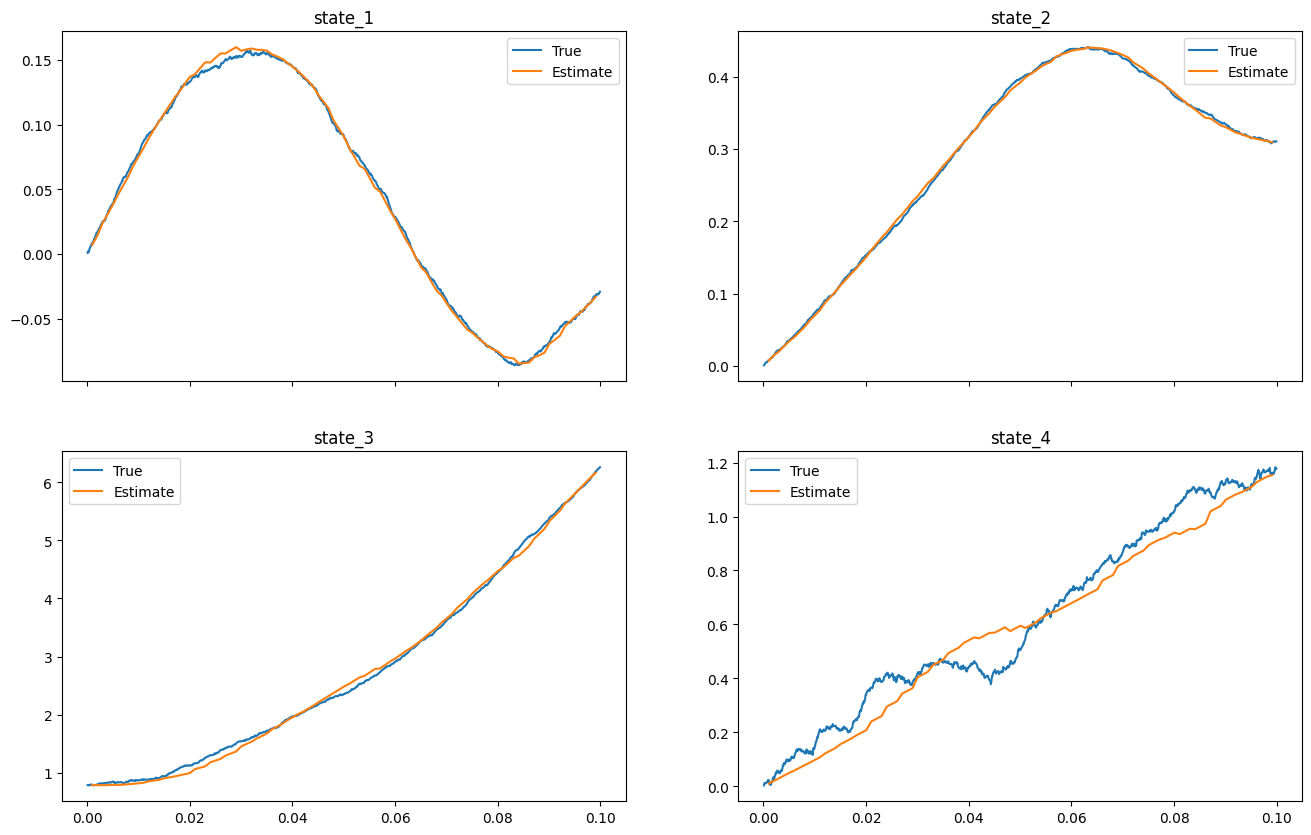

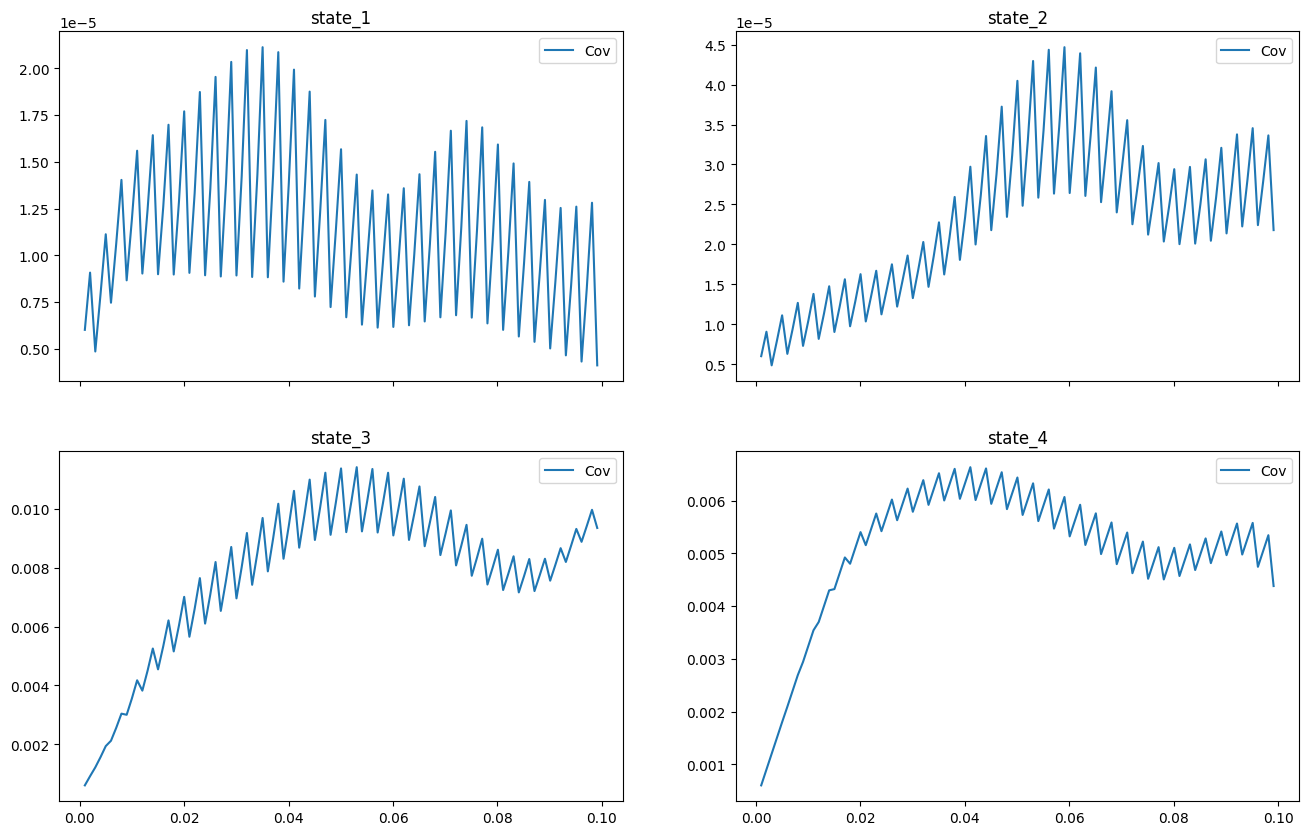

In [69]:
fig1, axs1 = plt.subplots(2, 2, sharex=True, figsize=(16, 10))
axs1 = axs1.flatten()
for i in range(4):
    axs1[i].plot(t[1:1000], traj[1:1000, i], label='True')
    axs1[i].plot(t_est[1:100], traj_est[1:100, i], label='Estimate')
    axs1[i].set_title(f'state_{i+1}')
    axs1[i].legend()
plt.show()

fig2, axs2 = plt.subplots(2, 2, sharex=True, figsize=(16, 10))
axs2 = axs2.flatten()
for i in range(4):
    axs2[i].plot(t_est[1:100], traj_cov[1:100, i, i], label='Cov')
    axs2[i].set_title(f'state_{i+1}')
    axs2[i].legend()
plt.show()
